Evaluation (for TFIDF-RF)

Load the validation datasets

In [1]:
import pandas as pd
import numpy as np

from pathlib import Path
from datetime import datetime
import pickle

In [2]:
import sys
 
# setting path for common utils script
sys.path.append('../')

import str_cleaning_functions
import dataset_loader

import evaluation_functions

In [3]:
DATASET_SIZE = 120
DATASET_IS_BALANCED = True


MAX_FEATURES = 20000        # max_features params for CountVectorizer

training_name = 'glove-cnn-{}_{}k_{}'.format(
    MAX_FEATURES,
    DATASET_SIZE,
    'bal' if DATASET_IS_BALANCED else 'imbal'
)

training_args_datetime = datetime(year=2023, month=12, day=18)
training_storing_folder = Path(training_name).resolve()

dataset_traintest, X_imbal_valid, y_imbal_valid, X_bal_valid, y_bal_valid = dataset_loader.load_presampled_dataset(DATASET_SIZE, DATASET_IS_BALANCED)

X_train, X_test, y_train, y_test = dataset_loader.create_traintest_dataset(dataset_traintest)

Loaded dataset size: 120k, is_balanced: True
Validation dataset imbalanced class distribution
review_score
1    774377
0    150928
Name: count, dtype: int64
Validation dataset balanced class distribution
review_score
0    150672
1    150672
Name: count, dtype: int64



Training dataset class distribution
review_score
0    54060
1    53940
Name: count, dtype: int64
Testing dataset class distribution
review_score
1    6060
0    5940
Name: count, dtype: int64





In [4]:
# data cleaning function
# same as training script

def cleaning_arr(str_arr):
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.clean(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.deEmojify(x))
    str_arr = str_arr.apply(lambda x: x.lower())
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_num(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_symbols(x))
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_punctuation(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.remove_stopword(x))      # no need to remove stopwords, as previous study shown including stopwords can improve performance (https://aclanthology.org/P12-1092.pdf)
    str_arr = str_arr.apply(lambda x: str_cleaning_functions.unify_whitespaces(x))
    # str_arr = str_arr.apply(lambda x: str_cleaning_functions.stemming(x))


    return str_arr

In [5]:
# applying data cleaning to all datasets
X_imbal_valid = cleaning_arr(X_imbal_valid)
X_bal_valid = cleaning_arr(X_bal_valid)

# X_bal_valid = X_bal_valid.to_numpy()
# y_bal_valid = y_bal_valid.to_numpy()

# X_imbal_valid = X_imbal_valid.to_numpy()
# y_imbal_valid = y_imbal_valid.to_numpy()


X_train = cleaning_arr(X_train)
X_test = cleaning_arr(X_test)

# X_train = X_train.to_numpy()
# X_test = X_test.to_numpy()
# y_train = y_train.to_numpy()
# y_test = y_test.to_numpy()

In [6]:
print('Validation (imbalanced) set')
print(len(X_imbal_valid))
print(len(y_imbal_valid))
print()
print('Validation (balanced) set')
print(len(X_bal_valid))
print(len(y_bal_valid))

print()
print()

print('Validation (imbalanced) set')
print(pd.Series(y_imbal_valid).value_counts())
print()
print('Validation (balanced) set')
print(pd.Series(y_bal_valid).value_counts())

print()
print()

print('validation (imbalanced) set datatype')
print(type(X_imbal_valid))
print(type(y_imbal_valid))
print()
print('validation (balanced) set datatype')
print(type(X_bal_valid))
print(type(y_bal_valid))

Validation (imbalanced) set
925305
925305

Validation (balanced) set
301344
301344


Validation (imbalanced) set
review_score
1    774377
0    150928
Name: count, dtype: int64

Validation (balanced) set
review_score
0    150672
1    150672
Name: count, dtype: int64


validation (imbalanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>

validation (balanced) set datatype
<class 'pandas.core.series.Series'>
<class 'pandas.core.series.Series'>


---

Load the models

Load the text vectorizer, model itself

Then transform the data through the vectorizer

In [7]:
import pickle

import tensorflow as tf
import keras

text_vectorizer_path = Path.joinpath(training_storing_folder, "{}_{}_textvectorizer.pkl".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
vectorizer_from_disk = pickle.load(open(text_vectorizer_path, 'rb'))
vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=MAX_FEATURES,
    output_sequence_length=512)

vectorizer.set_weights(vectorizer_from_disk['weights'])

model_path = Path.joinpath(training_storing_folder, "{}_{}_model.keras".format(
    training_name,
    training_args_datetime.strftime("%Y-%m-%d")
))
model = keras.models.load_model(model_path)

print('Loaded text vectorizer from {}'.format(text_vectorizer_path))
print('Loaded model from {}'.format(model_path))

2023-12-19 15:31:47.563873: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1 Max
2023-12-19 15:31:47.563939: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2023-12-19 15:31:47.563946: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2023-12-19 15:31:47.564033: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-12-19 15:31:47.564081: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Loaded text vectorizer from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_120k_bal/glove-cnn-20000_120k_bal_2023-12-18_textvectorizer.pkl
Loaded model from /Users/michaelcheng/Documents/MyDocs/HKU/COMP4801 FYP/FYP/NLP/dev-workspace/sa/glove-cnn_2023-12-12/glove-cnn-20000_120k_bal/glove-cnn-20000_120k_bal_2023-12-18_model.keras


In [8]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 100)         2000200   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         38528     
                                                                 
 max_pooling1d (MaxPooling1  (None, None, 128)         0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, None, 128)         0         
 g1D)                                                        

In [8]:
# create keras dataset object for evaluation
# same as training script

BATCH_SIZE = 128

import tensorflow as tf

# train_dataset = tf.data.Dataset.from_tensor_slices((X_train_subset, y_train_subset))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
valid_bal_dataset = tf.data.Dataset.from_tensor_slices((X_bal_valid, y_bal_valid))
valid_imbal_dataset = tf.data.Dataset.from_tensor_slices((X_imbal_valid, y_imbal_valid))

In [9]:
# batch first

test_dataset = test_dataset.batch(BATCH_SIZE)
valid_bal_dataset = valid_bal_dataset.batch(BATCH_SIZE)
valid_imbal_dataset = valid_imbal_dataset.batch(BATCH_SIZE)

In [10]:
# apply text vectorizer to test and validation datasets

test_dataset = test_dataset.map(lambda x, y: (vectorizer(x), y))
valid_bal_dataset = valid_bal_dataset.map(lambda x, y: (vectorizer(x), y))
valid_imbal_dataset = valid_imbal_dataset.map(lambda x, y: (vectorizer(x), y))

In [11]:
test_dataset = test_dataset.prefetch(tf.data.AUTOTUNE)
valid_bal_dataset = valid_bal_dataset.prefetch(tf.data.AUTOTUNE)
valid_imbal_dataset = valid_imbal_dataset.prefetch(tf.data.AUTOTUNE)

---

Evaluation

on test set

In [ ]:
eval_metrics_folder = Path.joinpath(training_storing_folder, 'eval_metrics')

if not eval_metrics_folder.exists():
    eval_metrics_folder.mkdir()

eval_test_prefix = 'test'
eval_valid_bal_prefix = 'valid_bal'
eval_valid_imbal_prefix = 'valid_imbal'

eval_test_folder = Path.joinpath(eval_metrics_folder, eval_test_prefix)
eval_valid_bal_folder = Path.joinpath(eval_metrics_folder, eval_valid_bal_prefix)
eval_valid_imbal_folder = Path.joinpath(eval_metrics_folder, eval_valid_imbal_prefix)

if not eval_test_folder.exists():
    eval_test_folder.mkdir()

if not eval_valid_bal_folder.exists():
    eval_valid_bal_folder.mkdir()

if not eval_valid_imbal_folder.exists():
    eval_valid_imbal_folder.mkdir()

In [12]:
y_test_pred_prob_raw = model.predict(test_dataset)

y_test_pred = np.argmax(y_test_pred_prob_raw, axis=1)

y_test_pred_prob = y_test_pred_prob_raw if len(np.unique(y_test_pred)) > 2 \
                else np.array([y_test_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_test_pred))])

 5/94 [>.............................] - ETA: 1s 

2023-12-18 18:32:22.633603: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


94/94 [==============================] - 1s 6ms/step


In [13]:
evaluation_functions.print_classification_report(y_test, y_test_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.73      0.79      5940
           1       0.77      0.90      0.83      6060

    accuracy                           0.81     12000
   macro avg       0.82      0.81      0.81     12000
weighted avg       0.82      0.81      0.81     12000



TN - True Negative 4307
FN - False Negative 601
TP - True Positive 5459
FP - False Positive 1633
Accuracy Rate: 0.8138333333333333
Misclassification Rate: 0.18616666666666667
F1-Score: 0.8121016622526538
ROC-AUC 0.8129546287962129


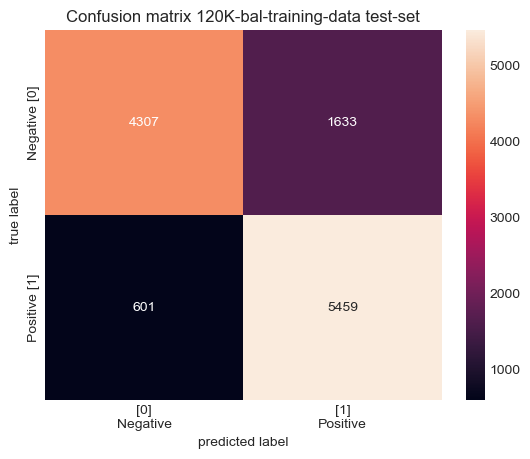

In [14]:
import matplotlib as plt
plt.style.use('seaborn-v0_8-dark')

evaluation_functions.create_confusion_matrix_graph(
    y_test,
    y_test_pred,
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-train test-set',
    save=False,
    save_filename=Path.joinpath(eval_test_folder, 'confusion_matrix_test.png')
)

0.6632756886799791


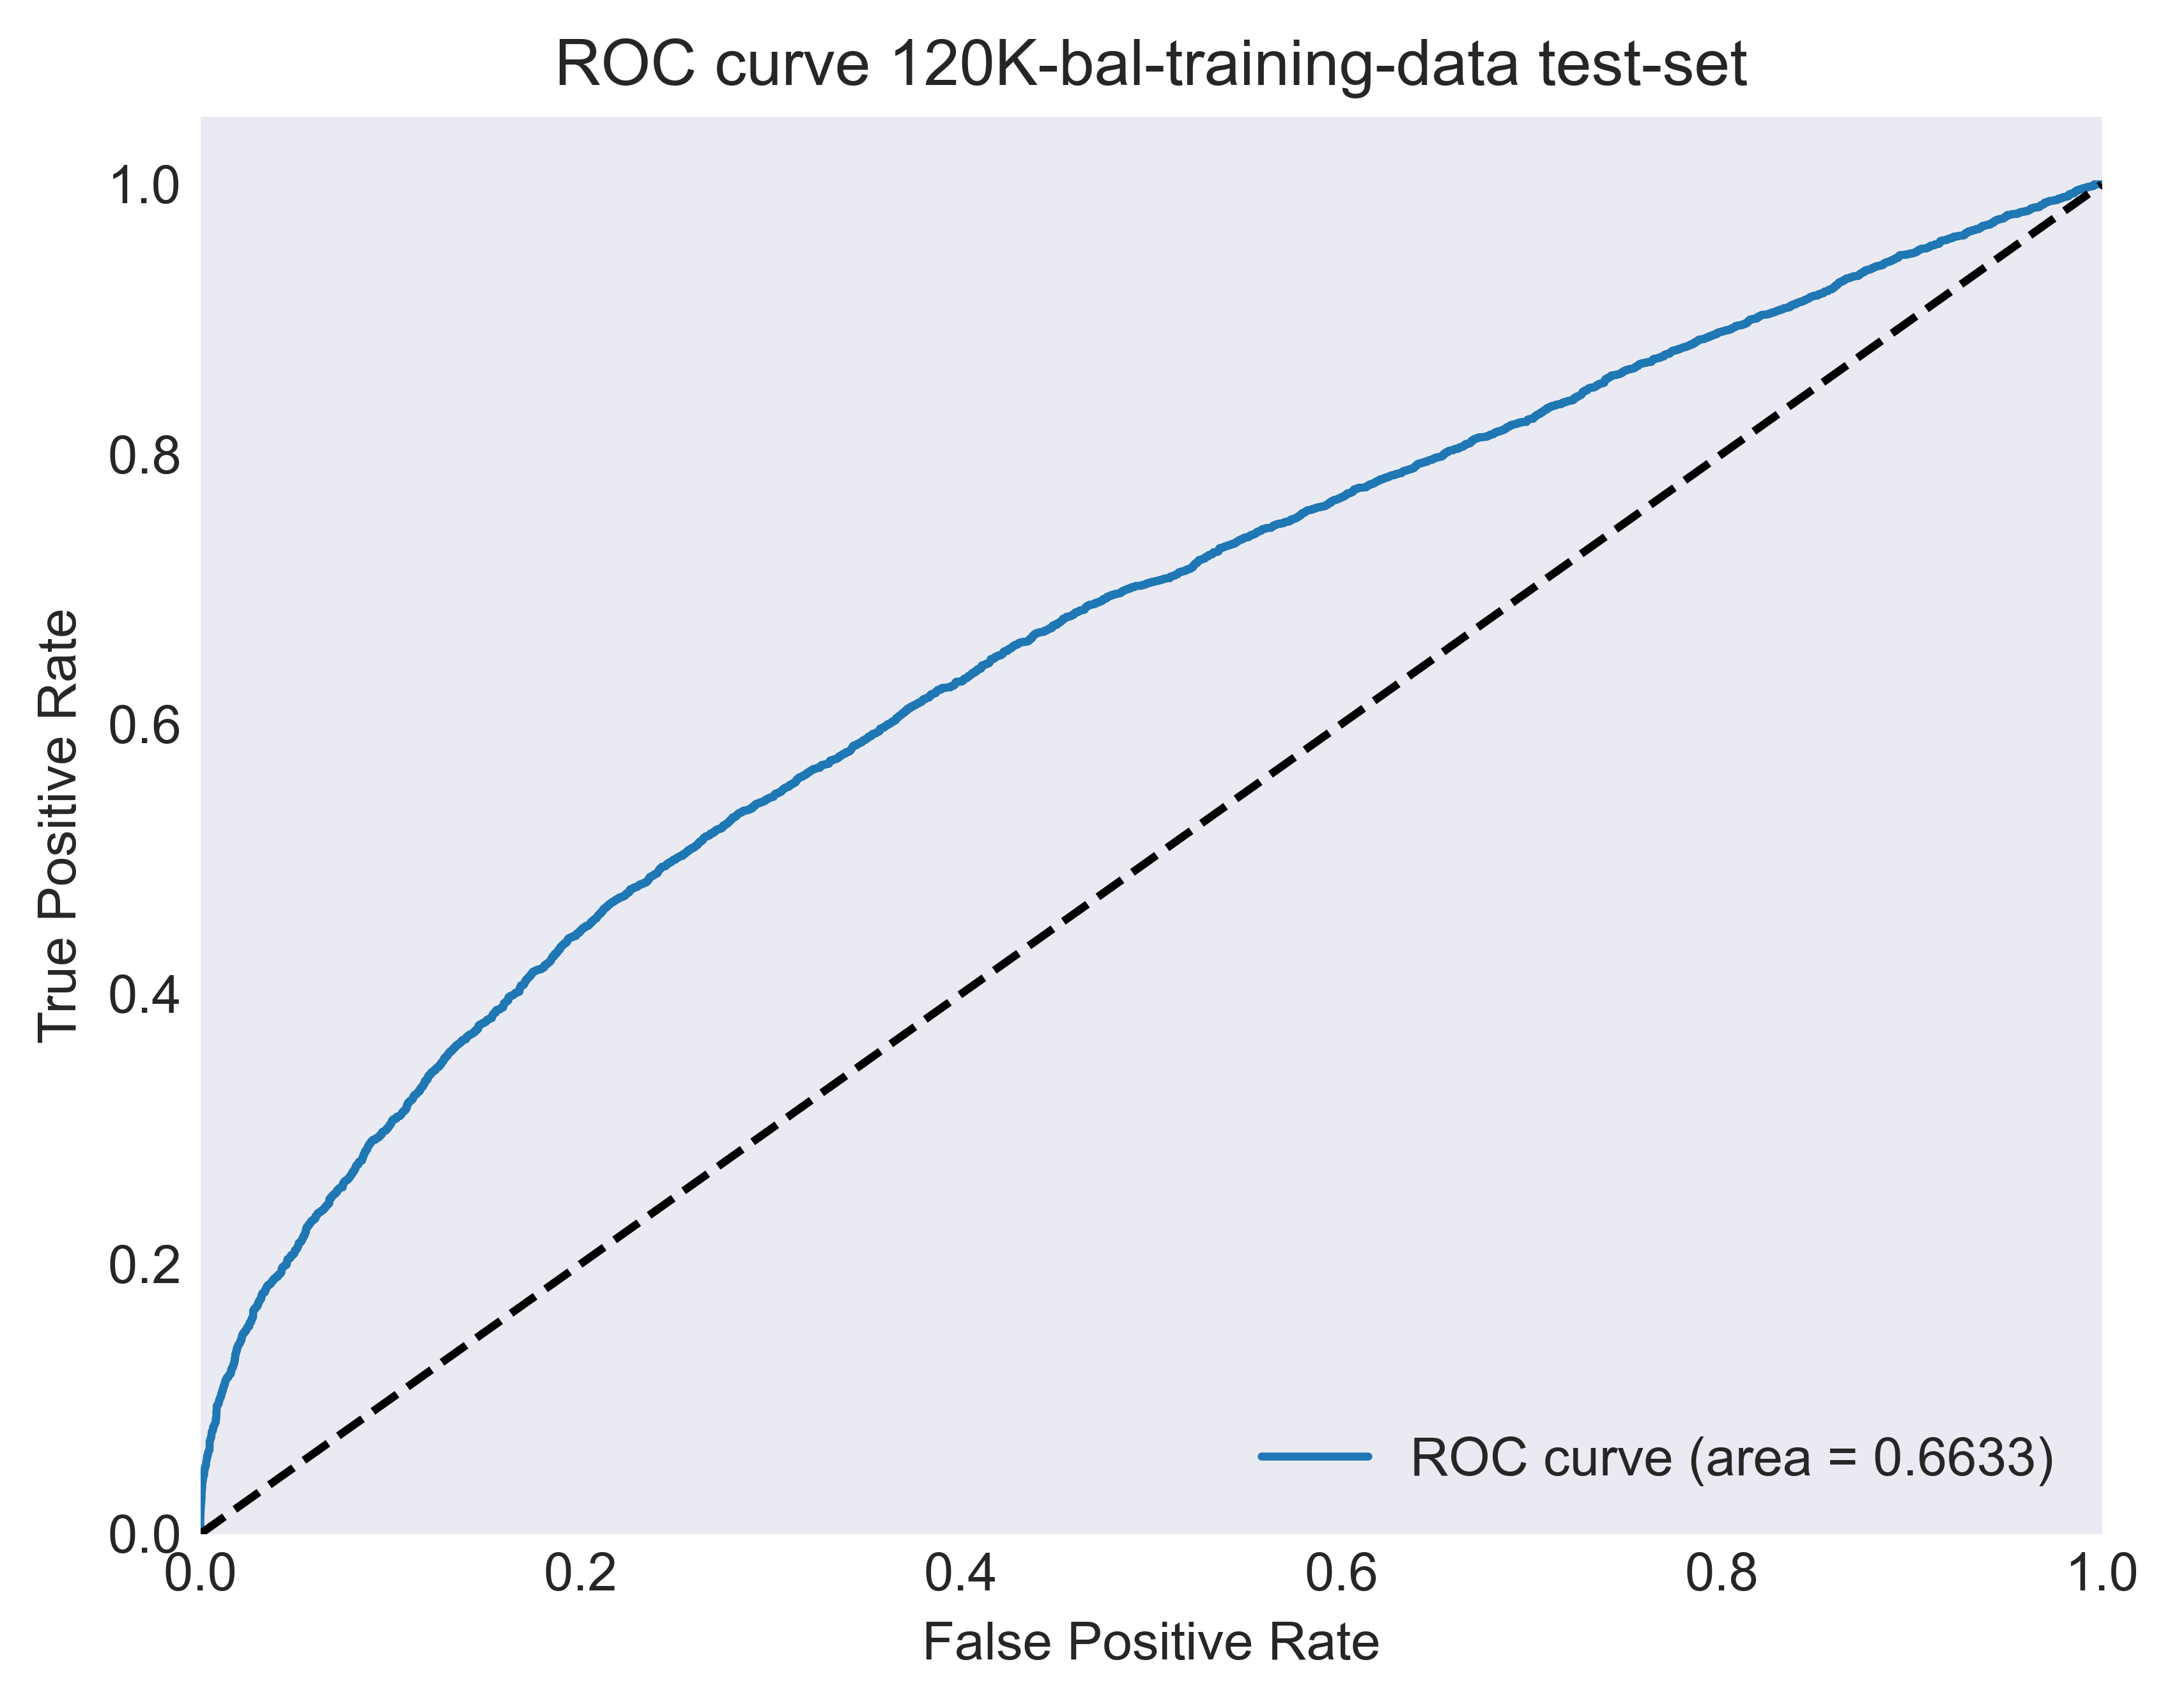

In [15]:
evaluation_functions.plot_roc_curve_binary(
    y_test,
    y_test_pred_prob,
    f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data test-set',
    save=False
)

on fixed balanced validation set

In [16]:
y_bal_valid_pred_prob_raw = model.predict(valid_bal_dataset)

y_bal_valid_pred = np.argmax(y_bal_valid_pred_prob_raw, axis=1)

y_bal_valid_pred_prob = y_bal_valid_pred_prob_raw if len(np.unique(y_bal_valid_pred)) > 2 \
                else np.array([y_bal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_bal_valid_pred))])

2355/2355 [==============================] - 13s 6ms/step


In [17]:
evaluation_functions.print_classification_report(y_bal_valid, y_bal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.88      0.73      0.80    150672
           1       0.77      0.90      0.83    150672

    accuracy                           0.82    301344
   macro avg       0.83      0.82      0.82    301344
weighted avg       0.83      0.82      0.82    301344



TN - True Negative 110399
FN - False Negative 15038
TP - True Positive 135634
FP - False Positive 40273
Accuracy Rate: 0.816452293724116
Misclassification Rate: 0.18354770627588404
F1-Score: 0.8151560497160033
ROC-AUC 0.816452293724116


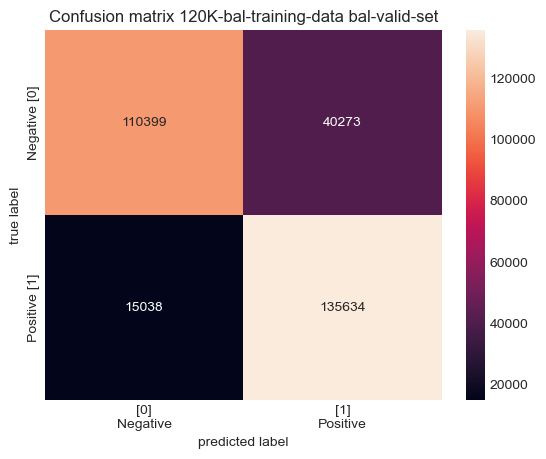

In [18]:
evaluation_functions.create_confusion_matrix_graph(
    y_bal_valid, y_bal_valid_pred, 
    f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set',
    save=False)

0.6585738348659722


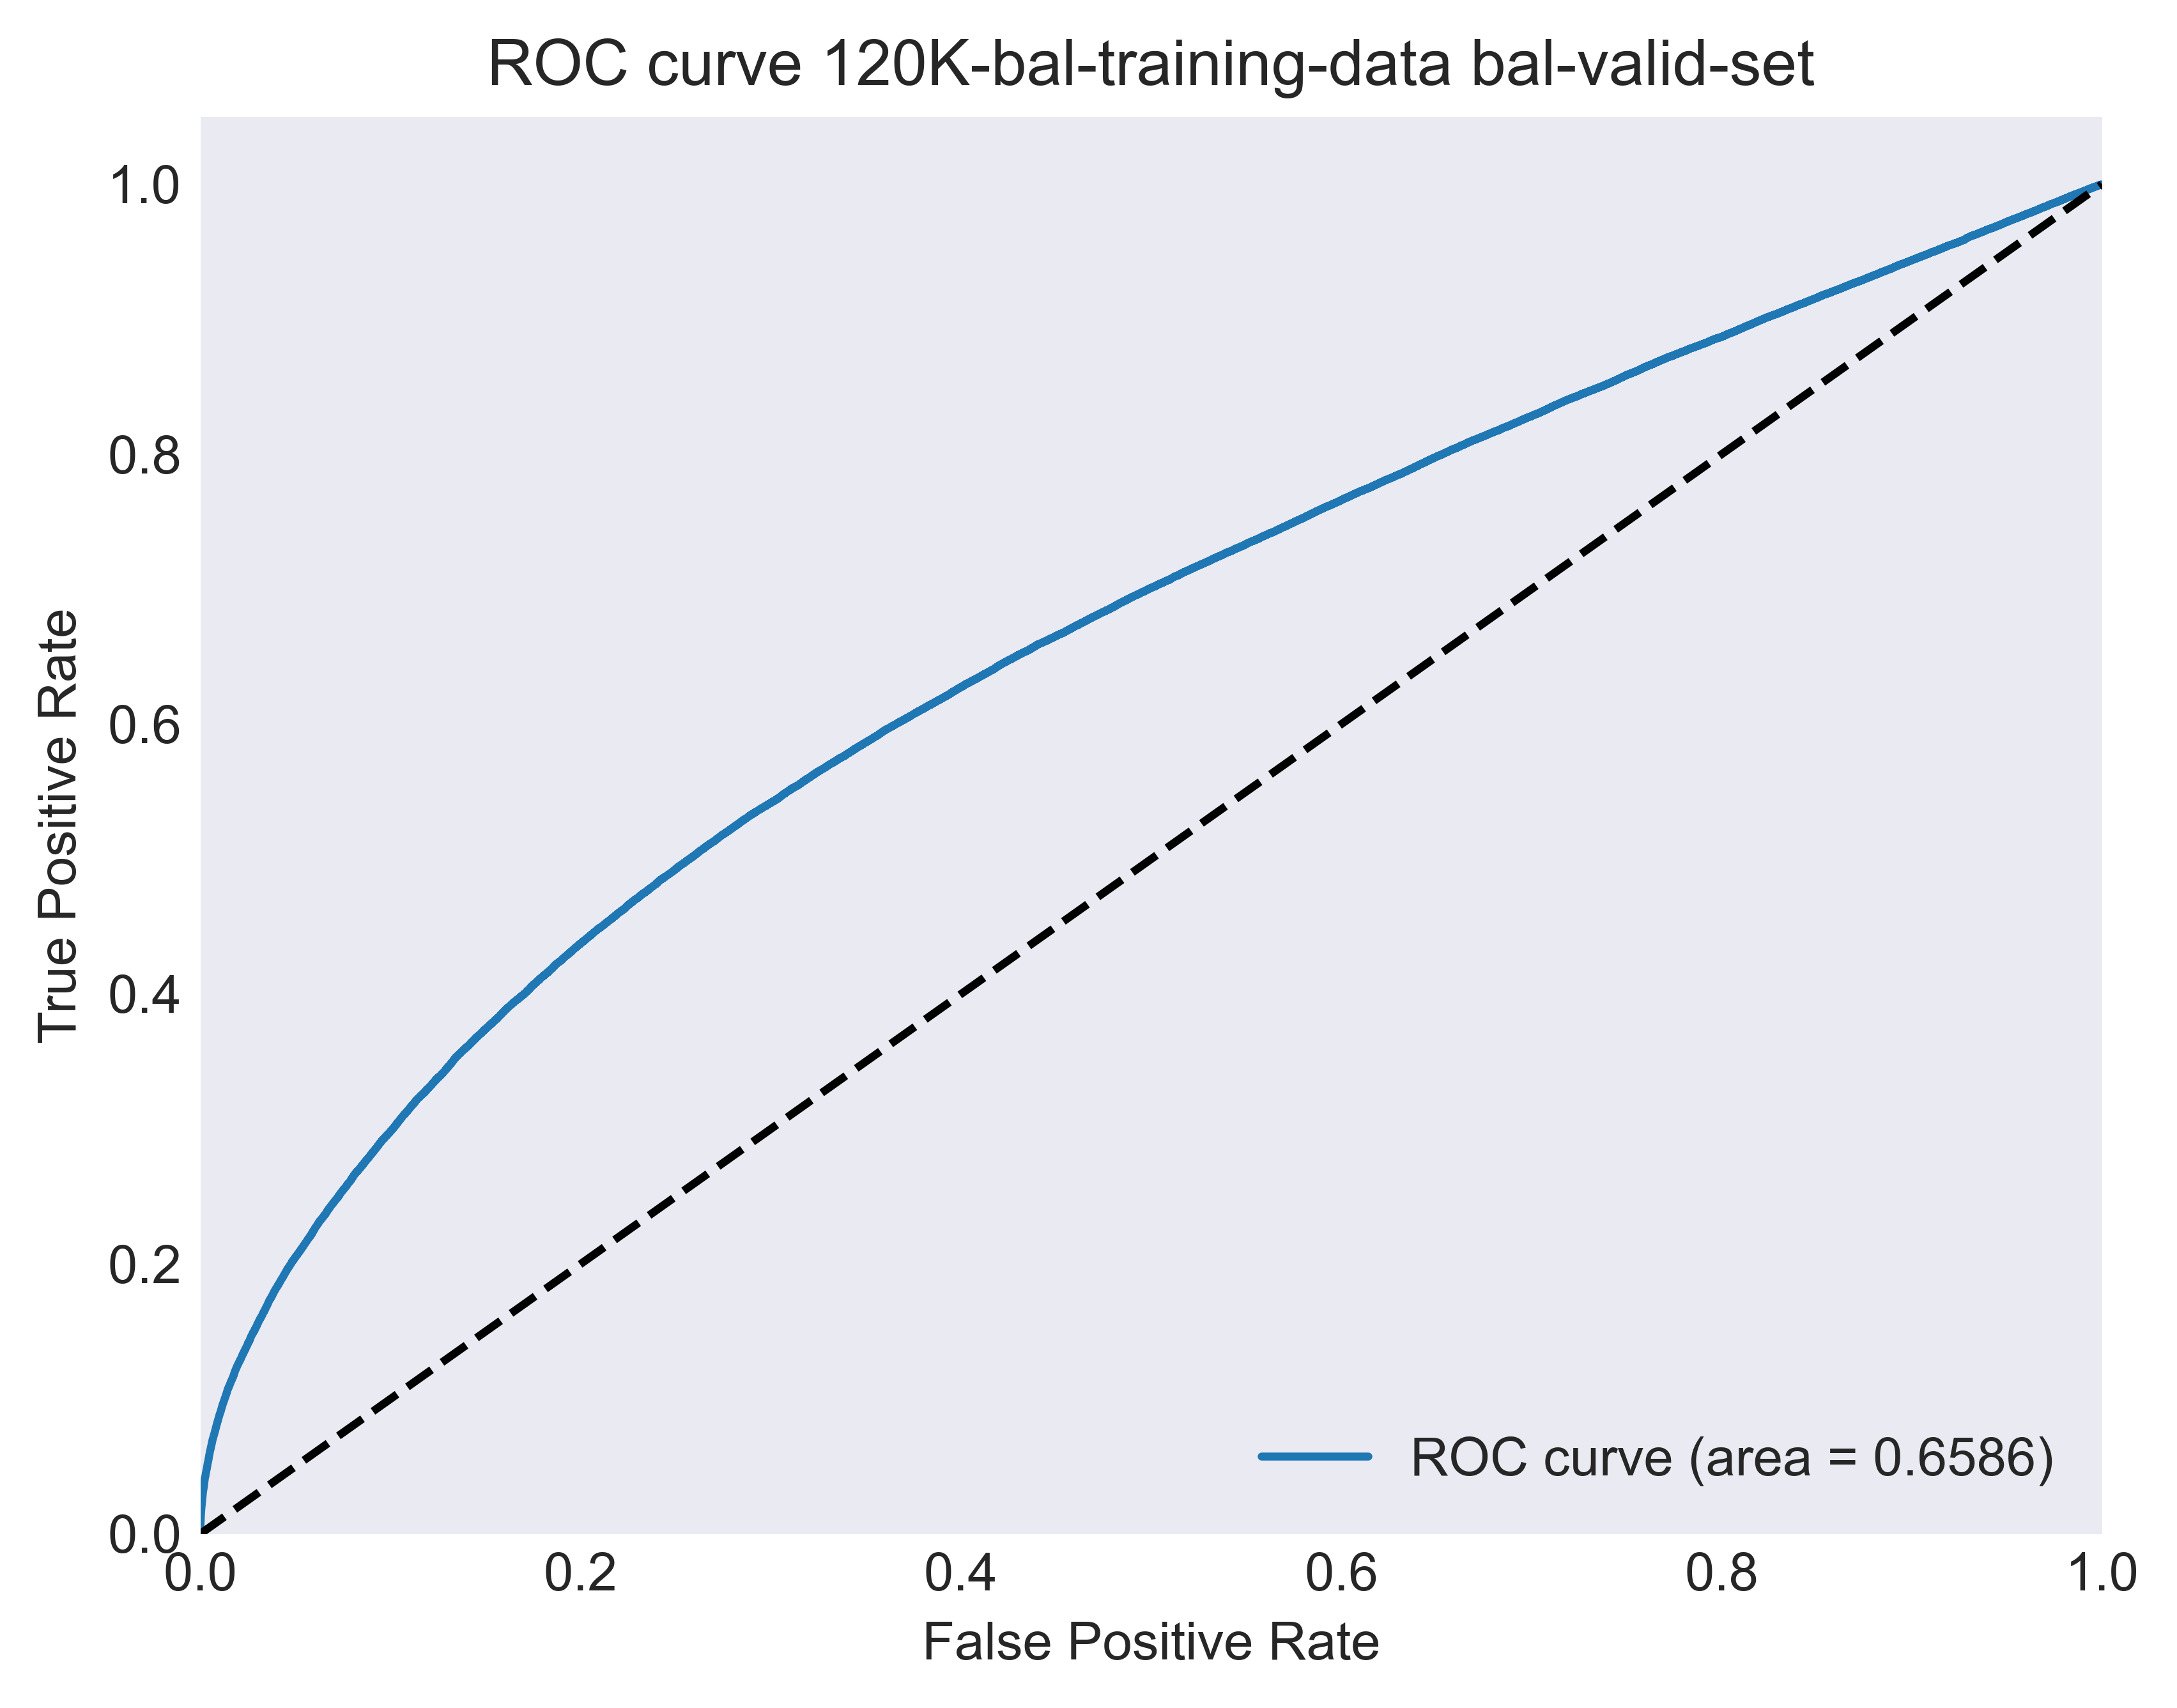

In [19]:
evaluation_functions.plot_roc_curve_binary(
    y_bal_valid, y_bal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}-training-data bal-valid-set', 
    save=False)

on fixed validation set (imbalanced)

In [20]:
y_imbal_valid_pred_prob_raw = model.predict(valid_imbal_dataset)

y_imbal_valid_pred = np.argmax(y_imbal_valid_pred_prob_raw, axis=1)

y_imbal_valid_pred_prob = y_imbal_valid_pred_prob_raw if len(np.unique(y_imbal_valid_pred)) > 2 \
                else np.array([y_imbal_valid_pred_prob_raw[i, pred] for i, pred in enumerate(list(y_imbal_valid_pred))])

7229/7229 [==============================] - 39s 5ms/step


In [21]:
evaluation_functions.print_classification_report(y_imbal_valid, y_imbal_valid_pred)

Classification report: 
               precision    recall  f1-score   support

           0       0.59      0.73      0.65    150928
           1       0.94      0.90      0.92    774377

    accuracy                           0.87    925305
   macro avg       0.77      0.82      0.79    925305
weighted avg       0.89      0.87      0.88    925305



TN - True Negative 110256
FN - False Negative 76932
TP - True Positive 697445
FP - False Positive 40672
Accuracy Rate: 0.8729024483818849
Misclassification Rate: 0.12709755161811512
F1-Score: 0.7872117615409838
ROC-AUC 0.8155867770910701


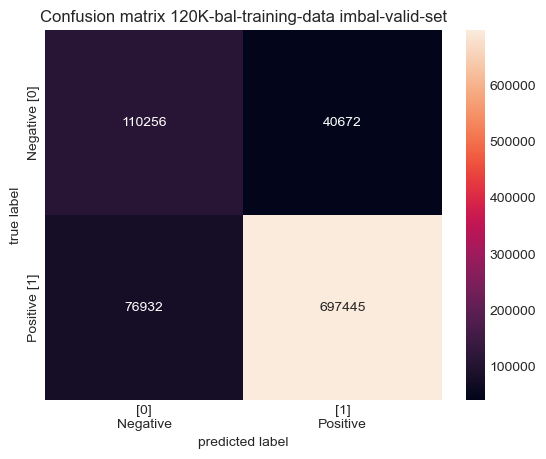

In [22]:
evaluation_functions.create_confusion_matrix_graph(
    y_imbal_valid, y_imbal_valid_pred, 
    title=f'Confusion matrix {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "ßimbal"}-training-data imbal-valid-set',
    save=False)

0.6607504836925339


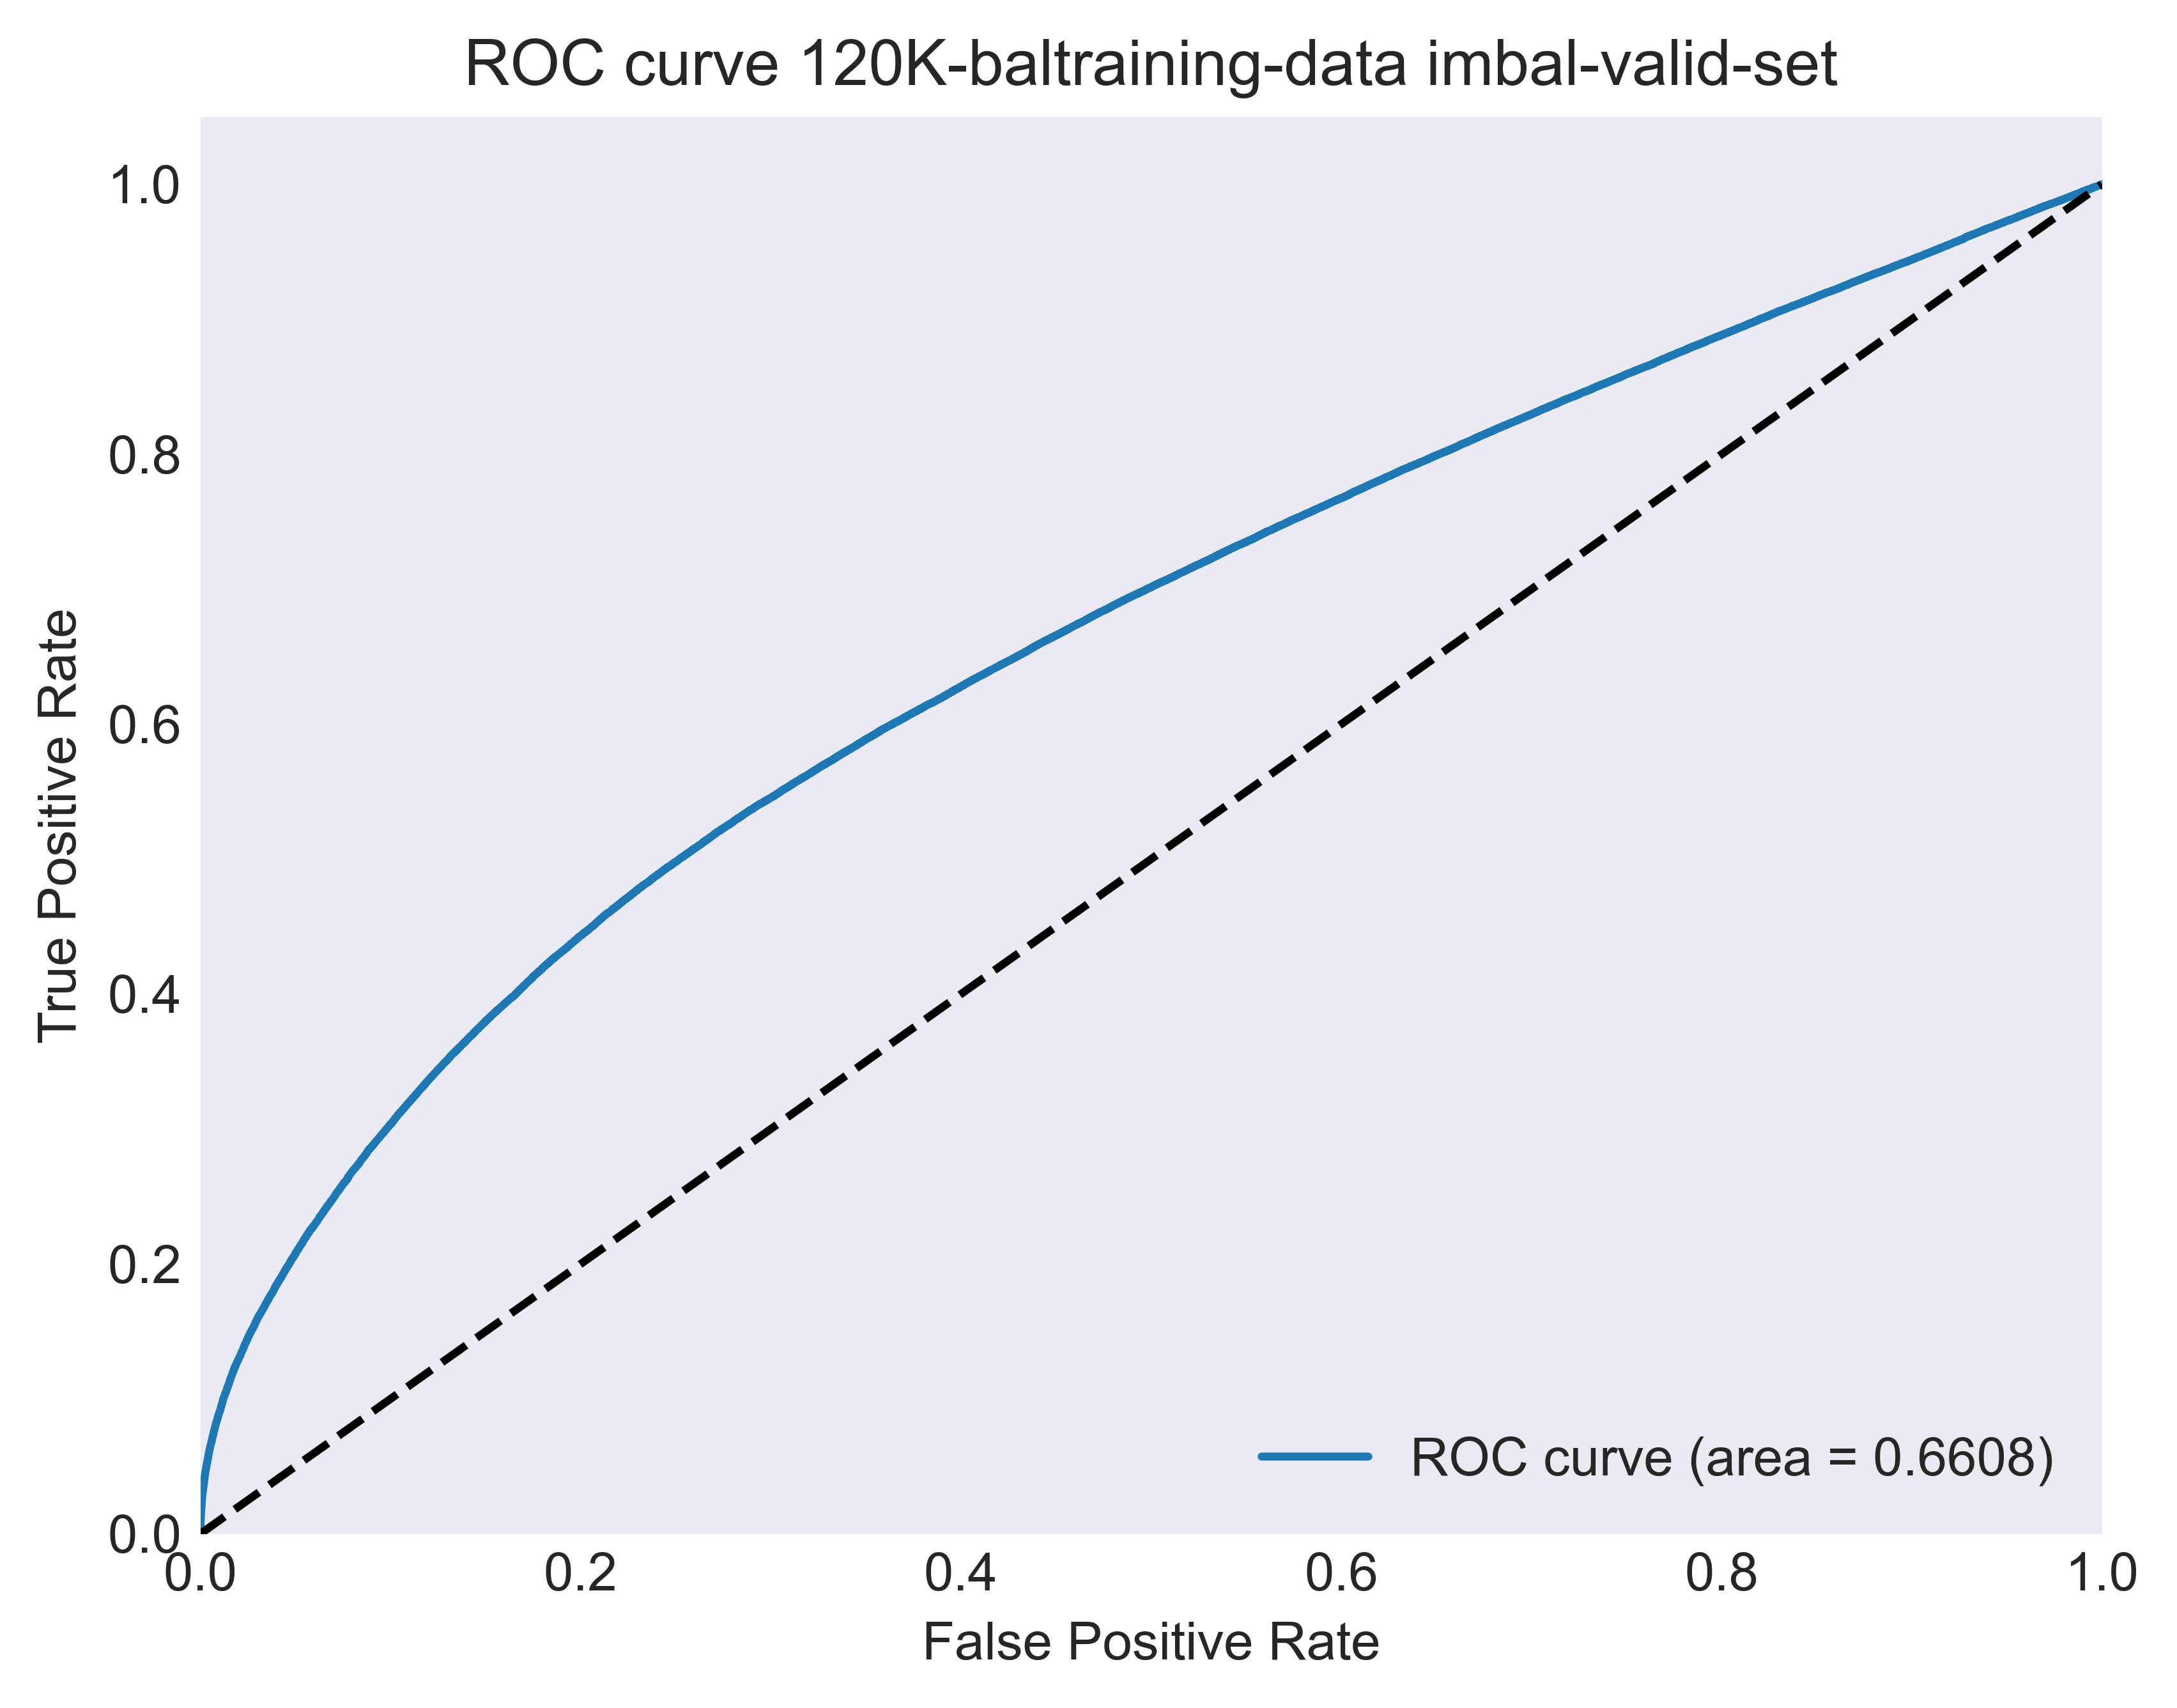

In [23]:
evaluation_functions.plot_roc_curve_binary(
    y_imbal_valid, y_imbal_valid_pred_prob, 
    title=f'ROC curve {DATASET_SIZE}K-{"bal" if DATASET_IS_BALANCED else "imbal"}training-data imbal-valid-set',
    save=False)

Evluation end